In [95]:
import numpy as np
def thomas_algorithm(out, a, b, d, cprime, dprime, X):
    cprime[0] = a / b
    dprime[0]
    for i in range(1, X):
        cprime[i] = a / (b - a * cprime[i - 1])
        dprime[i] = (d[i] - a * dprime[i - 1]) / (b - a * cprime[i - 1])

    out[X - 1] = dprime[X - 1]
    for i in range(X - 2, -1, -1):
        out[i] = dprime[i] - cprime[i] * out[i + 1]


In [96]:
X = 10
a = 1
b = -4
out = [0 for _ in range(X)]
d = [i for i in range(X)]
cprime = [0 for _ in range(X)]
dprime = [0 for _ in range(X)]

In [97]:
thomas_algorithm(out, a, b, d, cprime, dprime, X)

In [98]:
out

[-0.13396574225411223,
 -0.5358629690164489,
 -1.0094861338116834,
 -1.5020815662302844,
 -1.9988401311094544,
 -2.4932789582075334,
 -2.974275701720679,
 -3.4038238486751817,
 -3.6410196929800485,
 -3.160254923245012]

In [99]:
import scipy
A = np.zeros((3, X))
A[0, 1:] = a
A[1, :] = b
A[2, :-1] = a
sc_out = scipy.linalg.solve_banded((1, 1), A, d)

In [100]:
sc_out

array([-0.13396574, -0.53586297, -1.00948613, -1.50208157, -1.99884013,
       -2.49327896, -2.9742757 , -3.40382385, -3.64101969, -3.16025492])

In [101]:

INT = np.s_[1:-1, 1:-1]
XINT = np.s_[2:, 1:-1]
XMINT = np.s_[:-2, 1:-1]
YINT = np.s_[1:-1, 2:]
YMINT = np.s_[1:-1, :-2]

def bcu(u, K):
    # (sorry for no notation help)
    # Ut = 2Uw-Ub
    # top - sliding wall
    u[1:-1, 0, 0] = 2 * K - u[1:-1, 1, 0]
    #u[1:-1, 0, 0] = - u[1:-1, 1, 0]
    u[1:-1, 0, 1] = - u[1:-1, 1, 1]
    # bot - no slip
    u[1:-1, -1, :] = - u[1:-1, -2, :]
    # left - no slip
    u[0, 1:-1, :] = - u[1, 1:-1, :]
    # right - no slip
    u[-1, 1:-1, :] = - u[-2, 1:-1, :]
    # corners
    u[ 0,  0, :] = (u[ 1,  0, :] + u[ 0,  1, :]) / 2
    u[-1,  0, :] = (u[-2,  0, :] + u[-1,  1, :]) / 2
    u[ 0, -1, :] = (u[ 1, -1, :] + u[ 0, -2, :]) / 2
    u[-1, -1, :] = (u[-1, -2, :] + u[-2, -1, :]) / 2

def ei_adi(out, u, inter_u, xbuf1, xbuf2, X, K, dx, nu, dt):
    a = 1 * nu * dt / (dx * dx)
    b = -4 * nu * dt / (dx * dx)

    bcu(u, K)
    for j in range(1, X - 1):
        thomas_algorithm(inter_u[:, j, 0], -a, 1 + b, u[:, j, 0], xbuf1, xbuf2, X)
        thomas_algorithm(inter_u[:, j, 1], -a, 1 + b, u[:, j, 1], xbuf1, xbuf2, X)
    

    bcu(inter_u, K)
    for i in range(1, X - 1):
        thomas_algorithm(out[i, :, 0], -a, 1 + b, inter_u[i, :, 0], xbuf1, xbuf2, X)
        thomas_algorithm(out[i, :, 1], -a, 1 + b, inter_u[i, :, 1], xbuf1, xbuf2, X)
    

In [105]:
# (I - νΔt ∇2) un+1 = un

nu = 1 / 100
dt = 1e-3
dx = 1.0 / X

V = np.diagflat(np.ones(X) * -4 * nu * dt / (dx * dx), 0) + np.diagflat(np.ones(X - 1) * 1 * nu * dt / (dx * dx), 1) + np.diagflat(np.ones(X - 1) * 1 * nu * dt / (dx * dx), -1)
un = np.random.rand(X, X, 2)
bcu(un, 1.0)
I = np.eye(X, X)


In [106]:
out = np.zeros((X, X, 2))
inter_u = np.zeros((X, X, 2))
ei_adi(out, un, inter_u, cprime, dprime, X, 1.0, dx, nu, dt)
bcu(out, 1.0)

In [107]:
A = I - nu * dt * V
B = un

In [108]:
solve_X = np.linalg.solve(A, B)
bcu(solve_X, 1.0)

In [109]:
solve_X

array([[[ 5.47108223e-01, -1.39485111e-01],
        [-4.52891777e-01, -1.39485111e-01],
        [-9.18666021e-01, -6.99765738e-01],
        [-5.70767007e-01, -7.12345326e-01],
        [-7.68478054e-01, -8.06562968e-01],
        [-2.81629831e-01, -1.87393728e-01],
        [-8.85914645e-01, -2.53765841e-01],
        [-5.83834382e-01, -7.45797621e-01],
        [-6.23776157e-01, -6.13373965e-01],
        [-6.23776157e-01, -6.13373965e-01]],

       [[ 1.54710822e+00, -1.39485111e-01],
        [ 4.52891777e-01,  1.39485111e-01],
        [ 9.18666021e-01,  6.99765738e-01],
        [ 5.70767007e-01,  7.12345326e-01],
        [ 7.68478054e-01,  8.06562968e-01],
        [ 2.81629831e-01,  1.87393728e-01],
        [ 8.85914645e-01,  2.53765841e-01],
        [ 5.83834382e-01,  7.45797621e-01],
        [ 6.23776157e-01,  6.13373965e-01],
        [-6.23776157e-01, -6.13373965e-01]],

       [[ 1.28515318e+00, -9.13425688e-01],
        [ 7.14846818e-01,  9.13425688e-01],
        [ 9.26896425e-01,  5

In [110]:
out

array([[[ 0.54180619, -0.14224244],
        [-0.45819381, -0.14224244],
        [-0.92803998, -0.70679792],
        [-0.57720106, -0.72024978],
        [-0.7758562 , -0.81497455],
        [-0.28605114, -0.19051019],
        [-0.89454705, -0.25758699],
        [-0.59046437, -0.75277578],
        [-0.62964349, -0.61962695],
        [-0.62964349, -0.61962695]],

       [[ 1.54180619, -0.14224244],
        [ 0.45819381,  0.14224244],
        [ 0.92803998,  0.70679792],
        [ 0.57720106,  0.72024978],
        [ 0.7758562 ,  0.81497455],
        [ 0.28605114,  0.19051019],
        [ 0.89454705,  0.25758699],
        [ 0.59046437,  0.75277578],
        [ 0.62964349,  0.61962695],
        [-0.62964349, -0.61962695]],

       [[ 1.27759946, -0.92163007],
        [ 0.72240054,  0.92163007],
        [ 0.93688213,  0.53303343],
        [ 0.1297943 ,  0.64165939],
        [ 0.3250165 ,  1.00205121],
        [ 0.47632441,  0.53092479],
        [ 0.61976892,  0.82875049],
        [ 0.39949527,  0

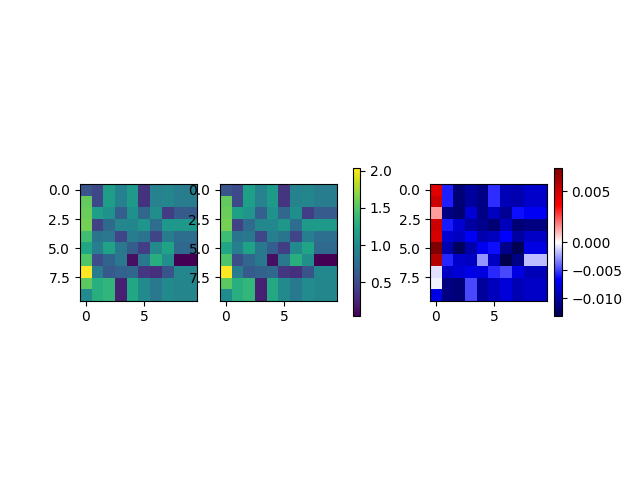

In [146]:
%matplotlib widget


from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import numpy as np

# same scale for first two
vmin = min(nsolve_X.min(), nout.min())
vmax = max(nsolve_X.max(), nout.max())
norm_main = Normalize(vmin=vmin, vmax=vmax)

# centered scale for difference
diff = nsolve_X - nout
norm_diff = TwoSlopeNorm(vmin=diff.min(), vcenter=0.0, vmax=diff.max())

fig, axs = plt.subplots(1, 3)

axs[0].imshow(nsolve_X, norm=norm_main, cmap="viridis")
axs[1].imshow(nout,     norm=norm_main, cmap="viridis")
im2 = axs[2].imshow(diff, norm=norm_diff, cmap="seismic")

fig.colorbar(axs[1].images[0], ax=axs[:2], shrink=0.4)
fig.colorbar(im2, ax=axs[2], shrink=0.4)
plt.show()

In [147]:
err_pct = 100 * np.linalg.norm(out - solve_X) / np.linalg.norm(solve_X)
err_pct

np.float64(0.9588786346799943)

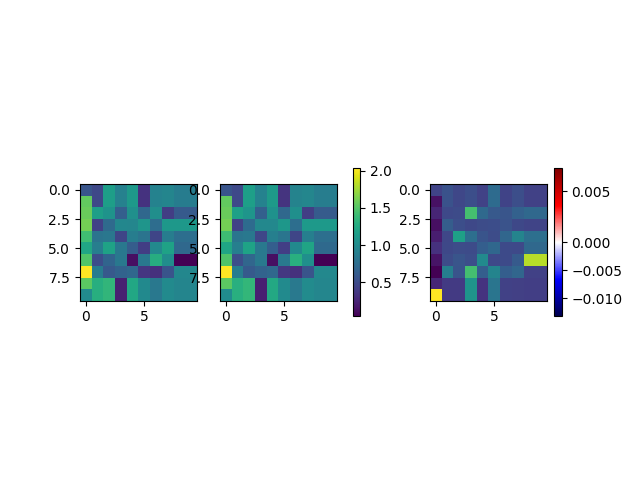

In [144]:
err_map = 100 * np.abs(out - solve_X) / (np.abs(solve_X) + 1e-12)
plt.imshow(err_map[..., 0])
plt.show()


In [123]:
err_pct = 100 * np.max(np.abs(out - solve_X)) / np.max(np.abs(solve_X))
err_pct

np.float64(0.5970800680972508)

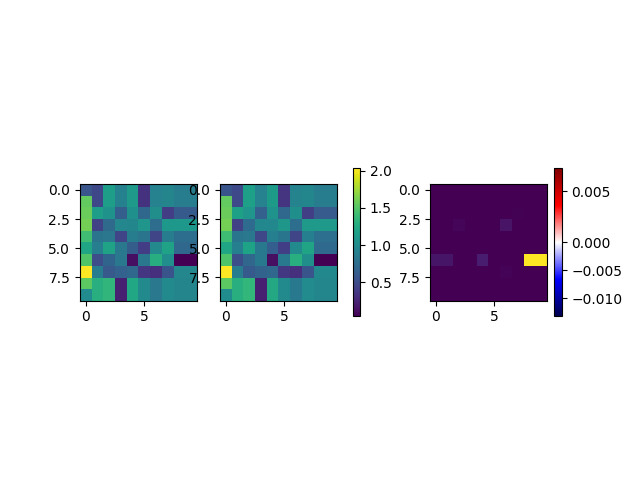

In [145]:
plt.imshow(err_map[..., 1])
plt.show()